# Modeling: Statistical

In this notebook, we define some statistical models and apply them to the framewise displacement data.

In [2]:
# add modules to path
import sys
sys.path.insert(1, '../src')

# library imports
import torch
import torch.nn as nn
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

import torch.nn.functional as F
from torch.distributions.normal import Normal

# project imports
import data_processing as dp
import train_eval as te
import models_nn as mnn

# autoreload all modules
%load_ext autoreload
%autoreload 2


In [3]:
# Load the data from the .npz file
data_dict_ppmi, pd_keys, control_keys = dp.load_ppmi_data()
data_dict_hcp = dp.load_hcp_data()


Loaded 320/364 PD subjects and 44/364 Control subjects
Loaded 1445 subject-run combinations


# Unsupervised Learning

In [31]:
X = []
for key in pd_keys + control_keys:
    a1, a2 = data_dict_ppmi[key]['framewise_displacement'][1:], data_dict_ppmi[key]['rmsd'][1:]
    a1 = (a1 - np.mean(a1)) / (np.std(a1) + 1e-8)
    a2 = (a2 - np.mean(a2)) / (np.std(a2) + 1e-8)
    x = np.vstack([a1, a2]).T
    X.append(x)
for k, v in data_dict_hcp.items():
    a1, a2 = v['framewise_displacement_equivalent'], v['relative_rms'][1:]
    a1 = (a1 - np.mean(a1)) / (np.std(a1) + 1e-8)
    a2 = (a2 - np.mean(a2)) / (np.std(a2) + 1e-8)
    x = np.vstack([a1, a2]).T
    X.append(x)
pd_mask = np.concatenate([np.ones(len(pd_keys)), np.zeros(len(control_keys)), np.zeros(len(data_dict_hcp))])
lengths = [len(x) for x in X]
X = np.concatenate(X, axis=0)
X.shape


(785975, 2)

In [ ]:
from hmmlearn.hmm import GaussianHMM

RNG_SEED = 42
np.random.seed(RNG_SEED)
n_iter = 10
n_init = 3
results = {}

# Cross-validate HMM with different numbers of components
# (Takes about 15 minutes on a single CPU core)
for n_components in range(2, 6):
    print(f"Training HMM with {n_components} components")
    for i in range(n_init):
        print(f"Initialization {i + 1}/{n_init}")
        ghmm = GaussianHMM(
            n_components=n_components,
            covariance_type='full',
            n_iter=n_iter * n_components,
            random_state=n_components * RNG_SEED + i,
            verbose=True
        )
        ghmm.fit(X, lengths=lengths)
        results[f'{n_components}_init_{i}'] = {
            'model': ghmm,
            'log_likelihoods': ghmm._compute_log_likelihood(X),
            'aic': ghmm.aic(X, lengths=lengths),
            'bic': ghmm.bic(X, lengths=lengths)
        }


Training HMM with 2 components
Initialization 1/3


         1 -2173825.55182688             +nan
         2 -2015593.19587536 +158232.35595152
         3 -1980056.80208414  +35536.39379122
         4 -1949777.27814291  +30279.52394124
         5 -1934862.03699758  +14915.24114532
         6 -1928835.47539380   +6026.56160378
         7 -1925704.67889704   +3130.79649676
         8 -1923648.72020378   +2055.95869325
         9 -1922183.75860066   +1464.96160312
        10 -1921118.95429864   +1064.80430202
        11 -1920341.69299557    +777.26130307
        12 -1919773.84270685    +567.85028872
        13 -1919358.91594562    +414.92676123
        14 -1919055.72145334    +303.19449228
        15 -1918834.17109945    +221.55035389
        16 -1918672.27796115    +161.89313830
        17 -1918553.97363891    +118.30432224
        18 -1918467.51595109     +86.45768782
        19 -1918404.32545335     +63.19049773
        20 -1918358.13452064     +46.19093272


Initialization 2/3


         1 -2417955.00877024             +nan
         2 -2008268.90119443 +409686.10757581
         3 -1959004.86997859  +49264.03121584
         4 -1932462.76540802  +26542.10457057
         5 -1922659.04375354   +9803.72165448
         6 -1919827.50765373   +2831.53609981
         7 -1918941.66936214    +885.83829159
         8 -1918595.90627208    +345.76309006
         9 -1918434.84953907    +161.05673301
        10 -1918351.59993171     +83.24960737
        11 -1918305.73716757     +45.86276413
        12 -1918279.23836933     +26.49879824
        13 -1918263.27828160     +15.96008774
        14 -1918253.29410919      +9.98417241
        15 -1918246.83261936      +6.46148983
        16 -1918242.52727134      +4.30534802
        17 -1918239.58917807      +2.93809327
        18 -1918237.54601768      +2.04316039
        19 -1918236.10465184      +1.44136584
        20 -1918235.07692384      +1.02772800


Initialization 3/3


         1 -2435596.60100258             +nan
         2 -2064074.77799819 +371521.82300439
         3 -2025960.77664722  +38114.00135097
         4 -2015549.62034843  +10411.15629880
         5 -2013060.88342943   +2488.73691900
         6 -2012050.82842154   +1010.05500789
         7 -2011448.41260330    +602.41581824
         8 -2011008.71317558    +439.69942772
         9 -2010645.74273170    +362.97044388
        10 -2010322.52708544    +323.21564626
        11 -2010022.02221169    +300.50487375
        12 -2009737.64315914    +284.37905255
        13 -2009467.30827211    +270.33488704
        14 -2009209.15135947    +258.15691264
        15 -2008961.57764355    +247.57371591
        16 -2008723.34961351    +238.22803004
        17 -2008493.55328781    +229.79632570
        18 -2008271.56191437    +221.99137345
        19 -2008056.99199379    +214.56992058
        20 -2007849.63042213    +207.36157166


Training HMM with 3 components
Initialization 1/3


         1 -2406350.58358817             +nan
         2 -2053267.33480795 +353083.24878022
         3 -1986472.22890912  +66795.10589883
         4 -1931768.81832973  +54703.41057939
         5 -1895163.32637337  +36605.49195636
         6 -1875151.34340342  +20011.98296995
         7 -1862214.46927833  +12936.87412509
         8 -1850556.31080030  +11658.15847803
         9 -1839643.16904245  +10913.14175785
        10 -1830755.78081080   +8887.38823165
        11 -1824457.93277726   +6297.84803354
        12 -1820322.58795692   +4135.34482034
        13 -1817687.85103317   +2634.73692375
        14 -1815937.74629676   +1750.10473641
        15 -1814672.01975129   +1265.72654547
        16 -1813661.75731267   +1010.26243862
        17 -1812781.17911940    +880.57819327
        18 -1811956.19339392    +824.98572547
        19 -1811141.13247012    +815.06092381
        20 -1810310.85865890    +830.27381122
        21 -1809457.86958341    +852.98907549
        22 -1808591.83499205    +8

Initialization 2/3


         1 -2185316.64062667             +nan
         2 -1965943.63755089 +219373.00307577
         3 -1937720.91701812  +28222.72053277
         4 -1916437.99914703  +21282.91787109
         5 -1897730.14195866  +18707.85718837
         6 -1880504.11574511  +17226.02621355
         7 -1864031.42114051  +16472.69460460
         8 -1848623.84187365  +15407.57926686
         9 -1835621.71715154  +13002.12472211
        10 -1825984.76988817   +9636.94726337
        11 -1819425.63329765   +6559.13659052
        12 -1814997.44171407   +4428.19158358
        13 -1811917.42635808   +3080.01535599
        14 -1809714.03400350   +2203.39235457
        15 -1808093.34010119   +1620.69390231
        16 -1806884.22391716   +1209.11618403
        17 -1805978.43569244    +905.78822471
        18 -1805301.04282003    +677.39287242
        19 -1804796.91085591    +504.13196412
        20 -1804424.05056000    +372.86029591
        21 -1804150.04593844    +274.00462156
        22 -1803949.87998548    +2

Initialization 3/3


         1 -2625440.87869088             +nan
         2 -2051380.84110843 +574060.03758246
         3 -1965393.21358915  +85987.62751928
         4 -1926979.87201339  +38413.34157576
         5 -1916211.13418058  +10768.73783281
         6 -1909563.22220774   +6647.91197284
         7 -1902023.05342016   +7540.16878758
         8 -1893836.08305861   +8186.97036155
         9 -1886704.07984659   +7132.00321202
        10 -1881528.53515174   +5175.54469485
        11 -1878007.14243088   +3521.39272085
        12 -1875534.02189870   +2473.12053219
        13 -1873691.96920103   +1842.05269767
        14 -1872262.79152805   +1429.17767298
        15 -1871135.72885706   +1127.06267098
        16 -1870246.54275542    +889.18610164
        17 -1869549.56745487    +696.97530055
        18 -1869007.06366054    +542.50379433
        19 -1868586.10449386    +420.95916667
        20 -1868258.32549828    +327.77899558
        21 -1868000.25616045    +258.06933783
        22 -1867793.31299347    +2

Training HMM with 4 components
Initialization 1/3


         1 -2168729.94954227             +nan
         2 -1945140.91868461 +223589.03085766
         3 -1892582.01574597  +52558.90293864
         4 -1858169.24788490  +34412.76786107
         5 -1833648.39737197  +24520.85051293
         6 -1815189.43738524  +18458.95998673
         7 -1802187.66065973  +13001.77672551
         8 -1793414.56522151   +8773.09543822
         9 -1787222.93275556   +6191.63246595
        10 -1782682.24344721   +4540.68930835
        11 -1779349.27388775   +3332.96955946
        12 -1776943.74665370   +2405.52723405
        13 -1775205.29864716   +1738.44800653
        14 -1773894.26950698   +1311.02914018
        15 -1772812.55645034   +1081.71305664
        16 -1771797.53692284   +1015.01952750
        17 -1770703.55529463   +1093.98162821
        18 -1769389.64305092   +1313.91224371
        19 -1767721.67716214   +1667.96588878
        20 -1765588.48851778   +2133.18864436
        21 -1762923.33256489   +2665.15595289
        22 -1759718.86099698   +32

Initialization 2/3


         1 -2535637.89567589             +nan
         2 -1937943.71830988 +597694.17736601
         3 -1892218.33546637  +45725.38284352
         4 -1861153.66611472  +31064.66935164
         5 -1841813.24986222  +19340.41625250
         6 -1830373.78136322  +11439.46849900
         7 -1822821.01392368   +7552.76743955
         8 -1817361.07288829   +5459.94103539
         9 -1813214.03506995   +4147.03781834
        10 -1809914.86034442   +3299.17472552
        11 -1807150.03188002   +2764.82846441
        12 -1804680.32133660   +2469.71054342
        13 -1802312.94100867   +2367.38032793
        14 -1799871.30962635   +2441.63138232
        15 -1797167.94457497   +2703.36505138
        16 -1793998.49175688   +3169.45281809
        17 -1790180.05070814   +3818.44104874
        18 -1785659.15053814   +4520.90017000
        19 -1780628.77228728   +5030.37825087
        20 -1775460.57030715   +5168.20198013
        21 -1770432.49975567   +5028.07055148
        22 -1765560.39613615   +48

Initialization 3/3


         1 -2401578.61703061             +nan
         2 -2006176.77896944 +395401.83806117
         3 -1937643.90516689  +68532.87380255
         4 -1884913.62979796  +52730.27536893
         5 -1846737.48562421  +38176.14417376
         6 -1818668.42118552  +28069.06443869
         7 -1800433.21427959  +18235.20690593
         8 -1789731.67112819  +10701.54315140
         9 -1783419.68800485   +6311.98312333
        10 -1779466.72674984   +3952.96125502
        11 -1776749.10968112   +2717.61706872
        12 -1774681.97469463   +2067.13498649
        13 -1772951.19254340   +1730.78215123
        14 -1771368.99445970   +1582.19808370
        15 -1769818.75235543   +1550.24210427
        16 -1768234.49829924   +1584.25405619
        17 -1766590.51844043   +1643.97985881
        18 -1764893.87925604   +1696.63918440
        19 -1763178.67891785   +1715.20033819
        20 -1761499.41762030   +1679.26129756
        21 -1759919.08430342   +1580.33331688
        22 -1758492.03118728   +14

Training HMM with 5 components
Initialization 1/3


         1 -2361554.66626188             +nan
         2 -1897861.11942896 +463693.54683292
         3 -1839568.36498081  +58292.75444815
         4 -1813139.74569709  +26428.61928372
         5 -1796631.23274119  +16508.51295590
         6 -1783950.34921414  +12680.88352705
         7 -1773849.28762237  +10101.06159177
         8 -1766162.39480094   +7686.89282143
         9 -1760540.85189754   +5621.54290339
        10 -1756418.21551643   +4122.63638111
        11 -1753242.42539598   +3175.79012045
        12 -1750520.97281302   +2721.45258297
        13 -1747805.60039643   +2715.37241659
        14 -1744806.97648687   +2998.62390956
        15 -1741559.96676794   +3247.00971892
        16 -1738333.91167820   +3226.05508975
        17 -1735345.23306892   +2988.67860928
        18 -1732615.60723907   +2729.62582985
        19 -1730021.24186653   +2594.36537254
        20 -1727382.95346740   +2638.28839913
        21 -1724527.03493919   +2855.91852821
        22 -1721338.47028829   +31

Initialization 2/3


         1 -2198231.50550717             +nan
         2 -1866652.77459112 +331578.73091605
         3 -1810065.03671961  +56587.73787151
         4 -1778020.06750765  +32044.96921196
         5 -1757298.63300055  +20721.43450710
         6 -1741842.72068205  +15455.91231850
         7 -1727874.85481209  +13967.86586996
         8 -1714025.01663678  +13849.83817532
         9 -1699838.01109271  +14187.00554407
        10 -1685130.68307925  +14707.32801346
        11 -1671110.22536852  +14020.45771073
        12 -1660269.59812317  +10840.62724535
        13 -1652678.73406606   +7590.86405711
        14 -1646841.33034238   +5837.40372368
        15 -1642320.04079656   +4521.28954582
        16 -1639137.73999705   +3182.30079951
        17 -1637034.32900249   +2103.41099456
        18 -1635638.20842063   +1396.12058186
        19 -1634679.03666004    +959.17176059
        20 -1633997.54226980    +681.49439024
        21 -1633501.72778973    +495.81448007
        22 -1633135.50988715    +3

Initialization 3/3


         1 -2746228.13932534             +nan
         2 -1945834.34554671 +800393.79377863
         3 -1861276.41541988  +84557.93012683
         4 -1809108.90060848  +52167.51481140
         5 -1776041.77569290  +33067.12491558
         6 -1753279.04606960  +22762.72962330
         7 -1735587.37500504  +17691.67106456
         8 -1721188.76767890  +14398.60732614
         9 -1709321.31907130  +11867.44860760
        10 -1699264.64866763  +10056.67040367
        11 -1691217.84460269   +8046.80406494
        12 -1685933.75417438   +5284.09042831
        13 -1682756.09976577   +3177.65440861
        14 -1680486.74132341   +2269.35844236
        15 -1678428.93817973   +2057.80314368
        16 -1676248.59154108   +2180.34663864
        17 -1673747.65318735   +2500.93835373
        18 -1670790.21140571   +2957.44178164
        19 -1667319.41545903   +3470.79594668
        20 -1663289.47445927   +4029.94099976
        21 -1658622.03308282   +4667.44137646
        22 -1653207.26868914   +54

In [ ]:
# Continue cross-validating HMM with different numbers of components
# (Takes about 30 minutes on a single CPU core)
for n_components in range(6, 8):
    print(f"Training HMM with {n_components} components")
    for i in range(n_init):
        print(f"Initialization {i + 1}/{n_init}")
        ghmm = GaussianHMM(
            n_components=n_components,
            covariance_type='full',
            n_iter=n_iter * n_components,
            random_state=n_components * RNG_SEED + i,
            verbose=True
        )
        ghmm.fit(X, lengths=lengths)
        results[f'{n_components}_init_{i}'] = {
            'model': ghmm,
            'log_likelihoods': ghmm._compute_log_likelihood(X),
            'aic': ghmm.aic(X, lengths=lengths),
            'bic': ghmm.bic(X, lengths=lengths)
        }


Training HMM with 6 components
Initialization 1/3


         1 -2280353.91381146             +nan
         2 -1901657.79559409 +378696.11821738
         3 -1837937.90288725  +63719.89270683
         4 -1793349.06533422  +44588.83755304
         5 -1763051.91696825  +30297.14836596
         6 -1743404.99832019  +19646.91864806
         7 -1730275.49401648  +13129.50430371
         8 -1720828.19848856   +9447.29552792
         9 -1713138.58411868   +7689.61436988
        10 -1705902.43183628   +7236.15228240
        11 -1698299.80173159   +7602.63010470
        12 -1689675.76614677   +8624.03558482
        13 -1679217.49615392  +10458.26999285
        14 -1666646.76969857  +12570.72645535
        15 -1653828.31274370  +12818.45695487
        16 -1643739.68542822  +10088.62731548
        17 -1637127.99769400   +6611.68773423
        18 -1632905.64742293   +4222.35027106
        19 -1630057.01813368   +2848.62928925
        20 -1628036.55626314   +2020.46187054
        21 -1626565.76440908   +1470.79185407
        22 -1625484.48887903   +10

Initialization 2/3


         1 -3169416.33843184             +nan
         2 -1952326.71324680 +1217089.62518504
         3 -1889109.90891292  +63216.80433388
         4 -1868882.07491424  +20227.83399868
         5 -1861188.68466804   +7693.39024620
         6 -1855579.27909956   +5609.40556848
         7 -1849457.22644137   +6122.05265819
         8 -1842034.32885606   +7422.89758531
         9 -1833299.39364809   +8734.93520797
        10 -1823815.89788876   +9483.49575933
        11 -1814260.78024472   +9555.11764404
        12 -1804915.58173771   +9345.19850701
        13 -1795848.39131741   +9067.19042030
        14 -1787541.97700662   +8306.41431079
        15 -1780802.48147554   +6739.49553108
        16 -1775938.13736022   +4864.34411532
        17 -1772614.33443066   +3323.80292956
        18 -1770316.85990430   +2297.47452635
        19 -1768647.19225131   +1669.66765299
        20 -1767351.13303927   +1296.05921204
        21 -1766265.72022191   +1085.41281737
        22 -1765275.81520950    +

Initialization 3/3


         1 -2541355.03613079             +nan
         2 -1889125.41379879 +652229.62233200
         3 -1837696.56590168  +51428.84789711
         4 -1800599.95561115  +37096.61029053
         5 -1770300.74894234  +30299.20666881
         6 -1745601.30038493  +24699.44855741
         7 -1724677.34479333  +20923.95559159
         8 -1707989.22056958  +16688.12422375
         9 -1695843.82012855  +12145.40044103
        10 -1687127.89295588   +8715.92717267
        11 -1680672.08760472   +6455.80535116
        12 -1675765.23951520   +4906.84808952
        13 -1671954.94762882   +3810.29188638
        14 -1668877.33370141   +3077.61392740
        15 -1666172.64044756   +2704.69325385
        16 -1663435.23382803   +2737.40661953
        17 -1660244.43472199   +3190.79910605
        18 -1656346.73481212   +3897.69990987
        19 -1651880.63024925   +4466.10456286
        20 -1647349.07864933   +4531.55159992
        21 -1643315.12928754   +4033.94936179
        22 -1640108.16477127   +32

Training HMM with 7 components
Initialization 1/3


         1 -2671318.85458021             +nan
         2 -1948035.41758570 +723283.43699451
         3 -1868549.23302520  +79486.18456050
         4 -1816108.57524318  +52440.65778202
         5 -1785334.47652137  +30774.09872181
         6 -1764071.02458549  +21263.45193588
         7 -1747275.56581039  +16795.45877510
         8 -1733525.34671182  +13750.21909858
         9 -1722483.65953784  +11041.68717398
        10 -1713208.13089913   +9275.52863872
        11 -1704457.46117823   +8750.66972090
        12 -1695404.83825701   +9052.62292122
        13 -1685699.53317163   +9705.30508538
        14 -1675162.53067762  +10537.00249401
        15 -1663770.20950421  +11392.32117341
        16 -1651931.89075796  +11838.31874626
        17 -1640460.08554711  +11471.80521085
        18 -1630002.93136870  +10457.15417841
        19 -1620630.40167153   +9372.52969716
        20 -1611904.30673444   +8726.09493710
        21 -1602972.48390124   +8931.82283319
        22 -1592708.87428407  +102

Initialization 2/3


         1 -2635520.41373785             +nan
         2 -2026390.32925908 +609130.08447876
         3 -1953289.92728082  +73100.40197826
         4 -1879992.87198666  +73297.05529416
         5 -1814906.47990093  +65086.39208573
         6 -1765070.26140219  +49836.21849874
         7 -1728315.64139490  +36754.62000729
         8 -1701394.16184736  +26921.47954754
         9 -1683095.52000014  +18298.64184722
        10 -1669879.47248090  +13216.04751924
        11 -1658523.50816320  +11355.96431769
        12 -1647984.04445341  +10539.46370980
        13 -1637858.40303592  +10125.64141749
        14 -1627637.62250627  +10220.78052966
        15 -1617161.28378534  +10476.33872092
        16 -1607085.35241135  +10075.93137399
        17 -1598645.51260300   +8439.83980835
        18 -1592376.12238423   +6269.39021877
        19 -1587435.58182743   +4940.54055680
        20 -1582395.81979960   +5039.76202782
        21 -1576002.42505121   +6393.39474840
        22 -1568008.49933992   +79

Initialization 3/3


         1 -2287842.10535756             +nan
         2 -1797552.36686377 +490289.73849379
         3 -1734833.74701859  +62718.61984517
         4 -1699637.82228764  +35195.92473096
         5 -1676438.15593925  +23199.66634839
         6 -1660147.32485792  +16290.83108133
         7 -1647660.61096510  +12486.71389282
         8 -1637517.32009766  +10143.29086744
         9 -1629202.26111144   +8315.05898622
        10 -1622449.87525828   +6752.38585316
        11 -1616791.06044526   +5658.81481302
        12 -1612201.35751585   +4589.70292941
        13 -1608872.60235067   +3328.75516518
        14 -1606331.61772825   +2540.98462242
        15 -1604212.38696414   +2119.23076411
        16 -1602338.03022892   +1874.35673522
        17 -1600623.66350418   +1714.36672474
        18 -1599033.53626328   +1590.12724090
        19 -1597556.22521124   +1477.31105205
        20 -1596188.10069117   +1368.12452006
        21 -1594925.05637366   +1263.04431751
        22 -1593760.80194866   +11

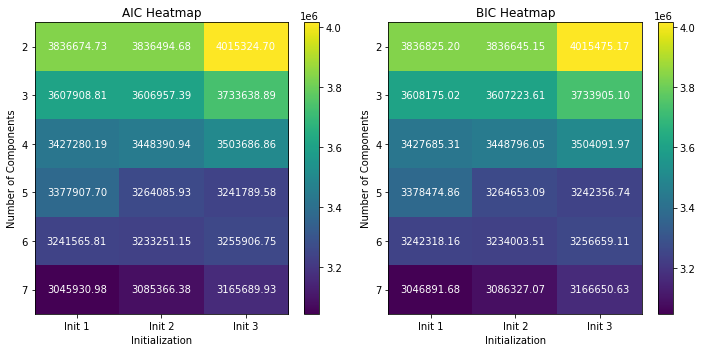

In [56]:
# Generate heatmaps of AIC and BIC
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
n_components_list = list(range(2, 8))
aic = np.array([[results[f'{n}_init_{i}']['aic'] for i in range(n_init)] for n in n_components_list])
bic = np.array([[results[f'{n}_init_{i}']['bic'] for i in range(n_init)] for n in n_components_list])

def plot_heatmap(data, ax, title):
    cax = ax.imshow(data, cmap='viridis', aspect='auto')
    ax.set_xticks(np.arange(n_init))
    ax.set_xticklabels([f'Init {i + 1}' for i in range(n_init)])
    ax.set_yticks(np.arange(len(n_components_list)))
    ax.set_yticklabels(n_components_list)
    ax.set_title(title)
    ax.set_xlabel('Initialization')
    ax.set_ylabel('Number of Components')
    # Annotate each cell with the value
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.text(j, i, f'{data[i, j]:.2f}', ha='center', va='center', color='white')
    plt.colorbar(cax, ax=ax)

plot_heatmap(aic, axs[0], 'AIC Heatmap')
plot_heatmap(bic, axs[1], 'BIC Heatmap')
plt.tight_layout()
plt.show()


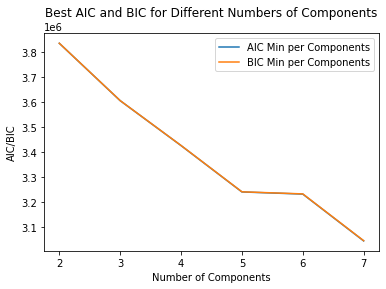

In [ ]:
plt.plot(aic.min(axis=1), label='AIC Min per Components')
plt.plot(bic.min(axis=1), label='BIC Min per Components')
plt.xticks(range(len(n_components_list)), n_components_list)
plt.xlabel('Number of Components')
plt.ylabel('AIC/BIC')
plt.title('Best AIC and BIC for Different Numbers of Components')
plt.legend()
plt.show()


In [ ]:
# Best model: 5 components, 3rd initialization
# covariance_type='full', n_components=5, n_iter=50, random_state=212
# Selected based on lowest AIC/BIC and elbow method
best_model = results['5_init_2']['model']
best_model


GaussianHMM(covariance_type='full', n_components=5, n_iter=50, random_state=212,
            verbose=True)

## Best Model Analysis

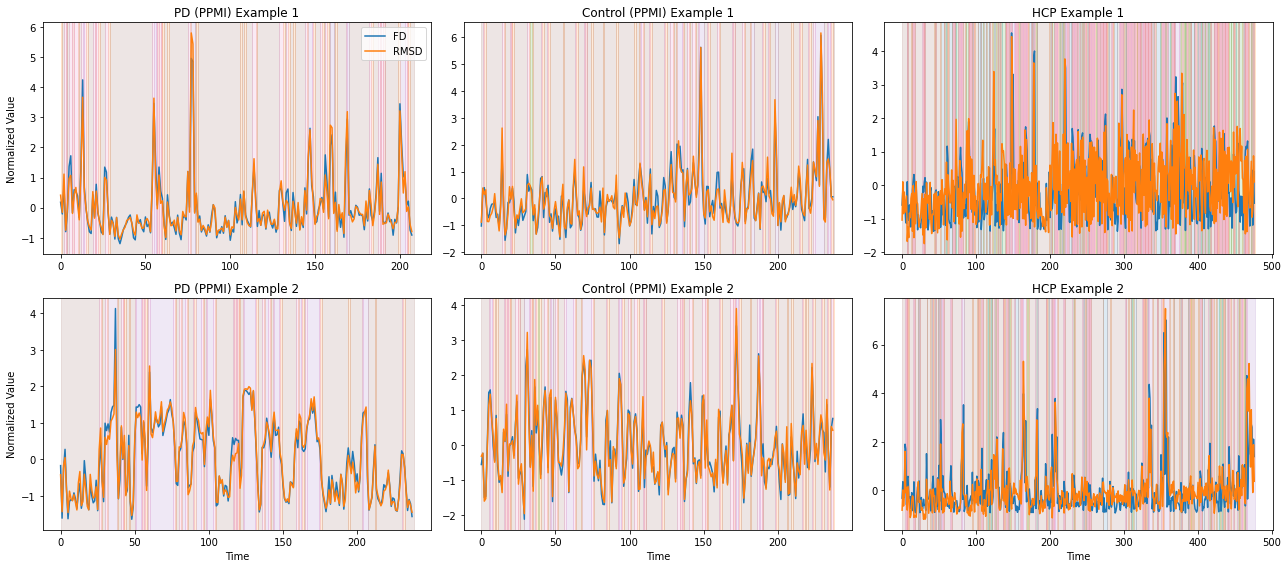

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Helper to get start/end indices for each sequence in X
seq_starts = np.cumsum([0] + lengths[:-1])
seq_ends = np.cumsum(lengths)

# Indices for PD, control, HCP
n_pd = len(pd_keys)
n_ctrl = len(control_keys)
n_hcp = len(data_dict_hcp)

# Select two samples for each group
pd_indices = [0, 1]
ctrl_indices = [n_pd, n_pd + 1]
hcp_indices = [n_pd + n_ctrl, n_pd + n_ctrl + 1]

fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharex=False)
groups = [
    ("PD (PPMI)", pd_indices),
    ("Control (PPMI)", ctrl_indices),
    ("HCP", hcp_indices)
]

for col, (title, indices) in enumerate(groups):
    for row, idx in enumerate(indices):
        ax = axs[row, col]
        start, end = seq_starts[idx], seq_ends[idx]
        sample = X[start:end]
        t = np.arange(len(sample))
        # Predict state sequence
        states = ghmm.predict(sample)
        # Plot both columns
        ax.plot(t, sample[:, 0], label='FD')
        ax.plot(t, sample[:, 1], label='RMSD')
        # Shade regions by state
        for s in np.unique(states):
            mask = states == s
            # Find contiguous regions
            in_region = False
            region_start = None
            for i, m in enumerate(mask):
                if m and not in_region:
                    region_start = i
                    in_region = True
                elif not m and in_region:
                    ax.axvspan(region_start, i, color=f"C{s}", alpha=0.15)
                    in_region = False
            if in_region:
                ax.axvspan(region_start, len(mask), color=f"C{s}", alpha=0.15)
        ax.set_title(f"{title} Example {row+1}")
        if row == 1:
            ax.set_xlabel("Time")
        if col == 0:
            ax.set_ylabel("Normalized Value")
        if row == 0 and col == 0:
            ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [73]:
import pandas as pd

states = best_model.predict(X)  # Predict states for the entire dataset
n_states = states.max() + 1  # number of unique states
n_samples = len(seq_starts)

# For each state, compute empirical mean/var for both features
means = []
vars_ = []
for s in range(n_states):
    mask = states == s
    means.append(X[mask].mean(axis=0))
    vars_.append(X[mask].var(axis=0))

means = np.array(means)
vars_ = np.array(vars_)

# For each sample, compute proportion of time spent in each state
proportions = np.zeros((n_samples, n_states))
for i in range(n_samples):
    st, en = seq_starts[i], seq_ends[i]
    sample_states = states[st:en]
    for s in range(n_states):
        proportions[i, s] = np.mean(sample_states == s)

# Group indices
n_pd = len(pd_keys)
n_ctrl = len(control_keys)
pd_idx = np.arange(n_pd)
ctrl_hcp_idx = np.arange(n_pd, n_samples)

# For each state, compute total proportion and percentiles for each group
rows = []
for s in range(n_states):
    # Empirical mean/var
    mean0, mean1 = means[s, 0], means[s, 1]
    var0, var1 = vars_[s, 0], vars_[s, 1]
    # Proportion in each group
    prop_pd = proportions[pd_idx, s].sum() / n_pd
    prop_ctrl_hcp = proportions[ctrl_hcp_idx, s].sum() / (n_samples - n_pd)
    # Percentiles
    pct_pd = np.percentile(proportions[pd_idx, s], [5, 50, 95])
    pct_ctrl_hcp = np.percentile(proportions[ctrl_hcp_idx, s], [5, 50, 95])
    rows.append({
        "State": s,
        "Mean_FD": mean0,
        "Var_FD": var0,
        "Mean_RMSD": mean1,
        "Var_RMSD": var1,
        "Prop_Total_PD": prop_pd,
        "Prop_Total_CtrlHCP": prop_ctrl_hcp,
        "PD_5th": pct_pd[0],
        "PD_50th": pct_pd[1],
        "PD_95th": pct_pd[2],
        "CtrlHCP_5th": pct_ctrl_hcp[0],
        "CtrlHCP_50th": pct_ctrl_hcp[1],
        "CtrlHCP_95th": pct_ctrl_hcp[2],
    })

df_states = pd.DataFrame(rows)
pd.set_option('display.precision', 4)
display(df_states)


,State,Mean_FD,Var_FD,Mean_RMSD,Var_RMSD,Prop_Total_PD,Prop_Total_CtrlHCP,PD_5th,PD_50th,PD_95th,CtrlHCP_5th,CtrlHCP_50th,CtrlHCP_95th
0,0,-0.6466,0.1576,-0.4995,0.2095,0.0034,0.4082,0.0000,0.0000,0.0210,0.1899,0.4214,0.5639
1,1,-0.1505,0.4894,-0.1529,0.4905,0.9365,0.0484,0.8653,0.9462,0.9867,0.0000,0.0000,0.4512
2,2,1.8301,3.5303,1.8150,3.5407,0.0549,0.0482,0.0133,0.0504,0.1011,0.0042,0.0461,0.1065
3,3,0.3415,0.7081,0.9533,0.2994,0.0033,0.2637,0.0000,0.0000,0.0192,0.1048,0.2746,0.3648
4,4,0.4236,0.7198,-0.5280,0.3983,0.0019,0.2315,0.0000,0.0000,0.0097,0.0864,0.2390,0.3396


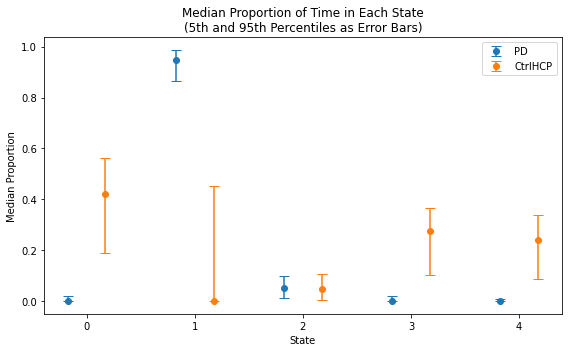

In [ ]:
# Boxplot of medians for PD and CtrlHCP with 5th and 95th percentiles as error bars

fig, ax = plt.subplots(figsize=(8, 5))

# Extract medians and error bars from df_states
pd_medians = df_states["PD_50th"]
ctrlhcp_medians = df_states["CtrlHCP_50th"]

pd_err = np.vstack([
    pd_medians - df_states["PD_5th"],
    df_states["PD_95th"] - pd_medians
])
ctrlhcp_err = np.vstack([
    ctrlhcp_medians - df_states["CtrlHCP_5th"],
    df_states["CtrlHCP_95th"] - ctrlhcp_medians
])

positions = np.arange(len(df_states))
width = 0.35

ax.errorbar(
    positions - width/2, pd_medians, yerr=pd_err, fmt='o', label='PD', capsize=5
)
ax.errorbar(
    positions + width/2, ctrlhcp_medians, yerr=ctrlhcp_err, fmt='o', label='CtrlHCP', capsize=5
)

ax.set_xticks(positions)
ax.set_xticklabels(df_states["State"])
ax.set_xlabel("State")
ax.set_ylabel("Median Proportion")
ax.set_title("Median Proportion of Time in Each State\n(5th and 95th Percentiles as Error Bars)")
ax.legend()
plt.tight_layout()
plt.show()


# Supervised Learning

In [ ]:
np.random.seed(RNG_SEED)

# Load the data from the .npz file
data_dict_ppmi, pd_keys, control_keys = dp.load_ppmi_data()
data_dict_hcp = dp.load_hcp_data()
hcp_keys = list(data_dict_hcp.keys())

# Train-val-test split
val_size = 0.15
test_size = 0.15
train_size = 1 - val_size - test_size

# Shuffle indices
np.random.shuffle(pd_keys)
np.random.shuffle(control_keys)
np.random.shuffle(hcp_keys)

# Split indices
train_pd = pd_keys[:int(train_size * len(pd_keys))]
val_pd = pd_keys[int(train_size * len(pd_keys)):int((train_size + val_size) * len(pd_keys))]
test_pd = pd_keys[int((train_size + val_size) * len(pd_keys)):]
train_control = control_keys[:int(train_size * len(control_keys))]
val_control = control_keys[int(train_size * len(control_keys)):int((train_size + val_size) * len(control_keys))]
test_control = control_keys[int((train_size + val_size) * len(control_keys)):]
train_hcp = hcp_keys[:int(train_size * len(hcp_keys))]
val_hcp = hcp_keys[int(train_size * len(hcp_keys)):int((train_size + val_size) * len(hcp_keys))]
test_hcp = hcp_keys[int((train_size + val_size) * len(hcp_keys)):]

# Combine into final splits and shuffle
train_keys = train_pd + train_control + train_hcp
val_keys = val_pd + val_control + val_hcp
test_keys = test_pd + test_control + test_hcp

# Create target arrays
y_train = np.concatenate([np.ones(len(train_pd)), np.zeros(len(train_control)), np.zeros(len(train_hcp))])
y_val = np.concatenate([np.ones(len(val_pd)), np.zeros(len(val_control)), np.zeros(len(val_hcp))])
y_test = np.concatenate([np.ones(len(test_pd)), np.zeros(len(test_control)), np.zeros(len(test_hcp))])

# Shuffle the keys for each split
train_idx = np.arange(len(train_keys))
val_idx = np.arange(len(val_keys))
test_idx = np.arange(len(test_keys))
np.random.shuffle(train_idx)
np.random.shuffle(val_idx)
np.random.shuffle(test_idx)

# Create final splits
train_keys = [train_keys[i] for i in train_idx]
val_keys = [val_keys[i] for i in val_idx]
test_keys = [test_keys[i] for i in test_idx]
y_train = y_train[train_idx].astype(int)
y_val = y_val[val_idx].astype(int)
y_test = y_test[test_idx].astype(int)


Loaded 320/364 PD subjects and 44/364 Control subjects
Loaded 1445 subject-run combinations


In [ ]:
# Manually check that sample i is correctly labeled
i = 4
a = train_keys[i]
print([a, y_train[i]])

#data_dict_hcp[a]
data_dict_ppmi[a]['participant_info']['group']


['sub-113369_run-02', 0]


'Control'

In [ ]:
def get_long_data(keys):
    """
    Extracts and normalizes framewise displacement and RMSD data for given keys.
    Prepares the data for input into hmmlearn models.
    Args:
        keys (list): List of keys to extract data for.
    Returns:
        X (np.ndarray): Concatenated and normalized feature matrix, shape (N, 2),
        lengths (list): List of lengths of each sequence corresponding to the keys.
    """

    X = []
    for k in keys:
        if k in data_dict_ppmi:
            a1, a2 = data_dict_ppmi[k]['framewise_displacement'][1:], data_dict_ppmi[k]['rmsd'][1:]
        elif k in data_dict_hcp:
            a1, a2 = data_dict_hcp[k]['framewise_displacement_equivalent'], data_dict_hcp[k]['relative_rms'][1:]
        else:
            raise ValueError(f"Key {k} not found in either dataset")
        a1 = (a1 - np.mean(a1)) / (np.std(a1) + 1e-8)
        a2 = (a2 - np.mean(a2)) / (np.std(a2) + 1e-8)
        x = np.vstack([a1, a2]).T
        X.append(x)
    lengths = [len(x) for x in X]
    X = np.concatenate(X, axis=0)
    
    return X, lengths


In [ ]:
X_train, lengths_train = get_long_data(train_keys)
X_val, lengths_val = get_long_data(val_keys)
X_test, lengths_test = get_long_data(test_keys)
X_train.shape, X_val.shape, X_test.shape


((548818, 2), (119389, 2), (117768, 2))

In [ ]:
from hmmlearn.hmm import GaussianHMM

RNG_SEED = 42
np.random.seed(RNG_SEED)
n_iter = 10
n_init = 3
results = {}

for n_components in range(2, 7):
    print(f"Training HMM with {n_components} components")
    for i in range(n_init):
        print(f"Initialization {i + 1}/{n_init}")
        ghmm = GaussianHMM(
            n_components=n_components,
            covariance_type='full',
            n_iter=n_iter * n_components,
            random_state=n_components * RNG_SEED + i,
            verbose=True
        )
        ghmm.fit(X_train, lengths=lengths_train)

        results[f'{n_components}_init_{i}'] = {
            'model': ghmm,
            'log_likelihoods': ghmm._compute_log_likelihood(X_train),
            'aic': ghmm.aic(X_train, lengths=lengths_train),
            'bic': ghmm.bic(X_train, lengths=lengths_train)
        }


Training HMM with 2 components
Initialization 1/3


         1 -1517400.47546146             +nan
         2 -1404572.69742126 +112827.77804020
         3 -1378913.08097254  +25659.61644871
         4 -1357804.44284766  +21108.63812488
         5 -1347677.86789512  +10126.57495255
         6 -1343565.51906144   +4112.34883368
         7 -1341387.56500941   +2177.95405203
         8 -1339944.19075047   +1443.37425893
         9 -1338913.94681256   +1030.24393792
        10 -1338165.84553700    +748.10127556
        11 -1337620.87525503    +544.97028197
        12 -1337223.79780461    +397.07745041
        13 -1336934.60490650    +289.19289812
        14 -1336724.11272572    +210.49218078
        15 -1336571.00259308    +153.11013263
        16 -1336459.69944520    +111.30314789
        17 -1336378.83040718     +80.86903801
        18 -1336320.09869871     +58.73170848
        19 -1336277.45815786     +42.64054085
        20 -1336246.50736539     +30.95079247


Initialization 2/3


         1 -1689757.16408730             +nan
         2 -1398656.87588727 +291100.28820003
         3 -1363576.74145061  +35080.13443666
         4 -1345509.21291381  +18067.52853680
         5 -1339064.94557307   +6444.26734073
         6 -1337219.00623885   +1845.93933422
         7 -1336635.21504839    +583.79119047
         8 -1336405.10374915    +230.11129924
         9 -1336297.74705953    +107.35668962
        10 -1336242.45925173     +55.28780779
        11 -1336212.17470463     +30.28454711
        12 -1336194.78447593     +17.39022869
        13 -1336184.37401576     +10.41046017
        14 -1336177.90020104      +6.47381472
        15 -1336173.73543356      +4.16476748
        16 -1336170.97741763      +2.75801593
        17 -1336169.10738942      +1.87002820
        18 -1336167.81582894      +1.29156048
        19 -1336166.91124491      +0.90458403
        20 -1336166.27112496      +0.64011995


Initialization 3/3


         1 -1674232.47034886             +nan
         2 -1436796.95658826 +237435.51376059
         3 -1413812.34205091  +22984.61453736
         4 -1409228.69508409   +4583.64696681
         5 -1407993.36908083   +1235.32600326
         6 -1407371.94600160    +621.42307923
         7 -1406965.37246740    +406.57353420
         8 -1406662.77943158    +302.59303582
         9 -1406415.72864384    +247.05078775
        10 -1406199.71149787    +216.01714597
        11 -1406002.18530310    +197.52619477
        12 -1405816.26395092    +185.92135217
        13 -1405637.67263025    +178.59132067
        14 -1405462.02096775    +175.65166251
        15 -1405283.62513096    +178.39583679
        16 -1405102.18762532    +181.43750564
        17 -1404920.91754951    +181.27007581
        18 -1404741.22074294    +179.69680657
        19 -1404563.21099489    +178.00974805
        20 -1404386.76566530    +176.44532959


Training HMM with 3 components
Initialization 1/3


         1 -1799780.63310531             +nan
         2 -1388420.28580930 +411360.34729601
         3 -1352668.55751868  +35751.72829062
         4 -1334015.04401915  +18653.51349953
         5 -1325064.49438938   +8950.54962977
         6 -1320867.48871557   +4197.00567381
         7 -1318600.51740655   +2266.97130902
         8 -1317234.86661221   +1365.65079434
         9 -1316344.65035487    +890.21625734
        10 -1315744.11726075    +600.53309412
        11 -1315319.52312766    +424.59413309
        12 -1315001.43618289    +318.08694477
        13 -1314747.19768930    +254.23849359
        14 -1314529.71001407    +217.48767523
        15 -1314331.48147050    +198.22854357
        16 -1314141.05619999    +190.42527051
        17 -1313950.74509519    +190.31110480
        18 -1313755.07821362    +195.66688157
        19 -1313549.57955362    +205.49866000
        20 -1313329.27075252    +220.30880110
        21 -1313089.21799025    +240.05276227
        22 -1312826.46138595    +2

Initialization 2/3


         1 -1515496.54666257             +nan
         2 -1353827.44026817 +161669.10639439
         3 -1333354.64650380  +20472.79376437
         4 -1315475.41900119  +17879.22750261
         5 -1298014.86428478  +17460.55471642
         6 -1283379.19823205  +14635.66605272
         7 -1273742.69763475   +9636.50059730
         8 -1268064.37634344   +5678.32129131
         9 -1264596.09429013   +3468.28205331
        10 -1262341.27766917   +2254.81662096
        11 -1260817.85454949   +1523.42311968
        12 -1259768.31531316   +1049.53923633
        13 -1259036.94197445    +731.37333871
        14 -1258521.62497368    +515.31700077
        15 -1258154.08188151    +367.54309217
        16 -1257892.96323579    +261.11864572
        17 -1257707.86209064    +185.10114515
        18 -1257576.52971187    +131.33237877
        19 -1257483.10919969     +93.42051217
        20 -1257416.37129429     +66.73790540
        21 -1257368.46729862     +47.90399567
        22 -1257333.91339694     +

Initialization 3/3


         1 -1534149.63535017             +nan
         2 -1351162.03356350 +182987.60178666
         3 -1321137.56041811  +30024.47314540
         4 -1301896.73929738  +19240.82112073
         5 -1289893.94887279  +12002.79042458
         6 -1282008.71519883   +7885.23367396
         7 -1276453.81251372   +5554.90268512
         8 -1272439.40433820   +4014.40817551
         9 -1269522.57925471   +2916.82508349
        10 -1267380.44618387   +2142.13307084
        11 -1265784.79387627   +1595.65230760
        12 -1264578.91759795   +1205.87627831
        13 -1263641.21019951    +937.70739844
        14 -1262874.24219638    +766.96800313
        15 -1262217.47854006    +656.76365632
        16 -1261621.96414551    +595.51439455
        17 -1261058.59165679    +563.37248873
        18 -1260512.33123154    +546.26042525
        19 -1259980.46096654    +531.87026500
        20 -1259480.63677018    +499.82419636
        21 -1259033.53581071    +447.10095947
        22 -1258646.39817229    +3

Training HMM with 4 components
Initialization 1/3


         1 -1601325.30425680             +nan
         2 -1369240.52967290 +232084.77458390
         3 -1341028.63074334  +28211.89892957
         4 -1324814.13429068  +16214.49645265
         5 -1314485.29513630  +10328.83915438
         6 -1305714.35797485   +8770.93716145
         7 -1295887.51028779   +9826.84768705
         8 -1282644.46958619  +13243.04070160
         9 -1266788.46695141  +15856.00263478
        10 -1252201.54438490  +14586.92256650
        11 -1241391.91979196  +10809.62459294
        12 -1234314.34212937   +7077.57766259
        13 -1229856.82471407   +4457.51741530
        14 -1226986.77435502   +2870.05035904
        15 -1225073.40029429   +1913.37406074
        16 -1223769.29235772   +1304.10793657
        17 -1222868.25468846    +901.03766926
        18 -1222236.65578119    +631.59890727
        19 -1221786.08246767    +450.57331352
        20 -1221458.70140281    +327.38106486
        21 -1221216.85770459    +241.84369822
        22 -1221035.74432542    +1

Initialization 2/3


         1 -1733174.40900354             +nan
         2 -1319845.92709277 +413328.48191076
         3 -1300808.99535115  +19036.93174162
         4 -1293642.00200856   +7166.99334259
         5 -1288855.66014691   +4786.34186165
         6 -1284262.70887802   +4592.95126889
         7 -1278970.13647126   +5292.57240676
         8 -1272564.35723027   +6405.77924099
         9 -1265047.77199429   +7516.58523598
        10 -1257237.97058537   +7809.80140891
        11 -1250482.96139075   +6755.00919462
        12 -1245433.06339925   +5049.89799150
        13 -1241892.64539199   +3540.41800726
        14 -1239399.89868766   +2492.74670433
        15 -1237576.12237338   +1823.77631428
        16 -1236177.08210898   +1399.04026440
        17 -1235054.30255750   +1122.77955148
        18 -1234044.72802912   +1009.57452838
        19 -1232989.00565926   +1055.72236986
        20 -1231786.91877907   +1202.08688020
        21 -1230394.22902280   +1392.68975627
        22 -1228855.89334192   +15

Initialization 3/3


         1 -1706040.07672758             +nan
         2 -1380829.54071831 +325210.53600927
         3 -1339887.84404729  +40941.69667101
         4 -1320723.94027526  +19163.90377204
         5 -1307723.43696137  +13000.50331389
         6 -1296403.67079136  +11319.76617001
         7 -1287072.25726779   +9331.41352356
         8 -1278459.38033211   +8612.87693568
         9 -1270749.25652241   +7710.12380970
        10 -1264643.91151807   +6105.34500434
        11 -1260011.59774563   +4632.31377244
        12 -1256530.91105685   +3480.68668878
        13 -1253866.20642303   +2664.70463382
        14 -1251748.46320277   +2117.74322026
        15 -1249996.99351142   +1751.46969135
        16 -1248501.70026648   +1495.29324495
        17 -1247202.85951596   +1298.84075051
        18 -1246076.10665608   +1126.75285989
        19 -1245115.54527803    +960.56137804
        20 -1244317.68017111    +797.86510693
        21 -1243670.90098926    +646.77918185
        22 -1243154.08060220    +5

Training HMM with 5 components
Initialization 1/3


         1 -1785686.42859307             +nan
         2 -1320030.36402956 +465656.06456351
         3 -1277683.04007945  +42347.32395011
         4 -1249042.93241599  +28640.10766346
         5 -1229480.43672669  +19562.49568931
         6 -1217161.92764954  +12318.50907715
         7 -1209622.68595003   +7539.24169951
         8 -1204702.13141264   +4920.55453739
         9 -1201249.54999878   +3452.58141386
        10 -1198692.68195713   +2556.86804165
        11 -1196706.33845847   +1986.34349865
        12 -1195123.37208756   +1582.96637092
        13 -1193832.30124517   +1291.07084238
        14 -1192731.20355081   +1101.09769436
        15 -1191742.20198630    +989.00156451
        16 -1190807.63272307    +934.56926323
        17 -1189880.40795902    +927.22476405
        18 -1188917.73557712    +962.67238190
        19 -1187878.79377292   +1038.94180420
        20 -1186727.44594652   +1151.34782640
        21 -1185440.50938808   +1286.93655844
        22 -1184014.26008117   +14

Initialization 2/3


         1 -1853190.67404297             +nan
         2 -1361799.58467388 +491391.08936909
         3 -1307922.58052612  +53877.00414776
         4 -1256612.80080437  +51309.77972176
         5 -1220039.13695181  +36573.66385256
         6 -1206182.40326421  +13856.73368759
         7 -1200270.00142971   +5912.40183451
         8 -1196627.73661184   +3642.26481787
         9 -1194065.25418247   +2562.48242937
        10 -1192181.89776118   +1883.35642129
        11 -1190764.20072828   +1417.69703290
        12 -1189634.80932608   +1129.39140220
        13 -1188641.10936743    +993.69995865
        14 -1187646.17430776    +994.93505967
        15 -1186499.83214506   +1146.34216270
        16 -1184998.14389531   +1501.68824975
        17 -1182840.66608497   +2157.47781035
        18 -1179619.14352121   +3221.52256376
        19 -1174931.88043005   +4687.26309116
        20 -1168706.02426945   +6225.85616060
        21 -1161506.52525850   +7199.49901095
        22 -1154476.87776232   +70

Initialization 3/3


         1 -1512788.94737017             +nan
         2 -1374173.37009053 +138615.57727964
         3 -1343546.56294619  +30626.80714433
         4 -1322693.11929943  +20853.44364676
         5 -1309589.93350101  +13103.18579842
         6 -1300197.48754412   +9392.44595688
         7 -1292173.77863629   +8023.70890783
         8 -1284240.62905074   +7933.14958555
         9 -1275698.73977602   +8541.88927472
        10 -1266237.30161041   +9461.43816561
        11 -1255871.39513392  +10365.90647650
        12 -1244932.87666814  +10938.51846578
        13 -1234177.70291172  +10755.17375642
        14 -1224719.72134378   +9457.98156793
        15 -1217299.20399926   +7420.51734453
        16 -1211787.10428281   +5512.09971645
        17 -1207609.73146216   +4177.37282065
        18 -1204233.59381758   +3376.13764459
        19 -1201291.28005678   +2942.31376080
        20 -1198581.91617434   +2709.36388243
        21 -1196052.19997951   +2529.71619484
        22 -1193732.05069125   +23

Training HMM with 6 components
Initialization 1/3


         1 -1774699.34884075             +nan
         2 -1362429.71106778 +412269.63777298
         3 -1314886.90278043  +47542.80828735
         4 -1293673.60115334  +21213.30162709
         5 -1280083.02263898  +13590.57851436
         6 -1269860.15114454  +10222.87149444
         7 -1261843.35057118   +8016.80057336
         8 -1255542.86388150   +6300.48668968
         9 -1250571.72739796   +4971.13648354
        10 -1246576.56404111   +3995.16335685
        11 -1243263.58296268   +3312.98107843
        12 -1240411.06104744   +2852.52191524
        13 -1237864.20000659   +2546.86104085
        14 -1235525.22855564   +2338.97145095
        15 -1233345.15242920   +2180.07612644
        16 -1231314.44759350   +2030.70483570
        17 -1229444.81825936   +1869.62933413
        18 -1227746.42874858   +1698.38951079
        19 -1226215.83854474   +1530.59020383
        20 -1224836.97712880   +1378.86141594
        21 -1223586.70426194   +1250.27286686
        22 -1222438.74278759   +11

Initialization 2/3


         1 -1865372.85202337             +nan
         2 -1354244.97037322 +511127.88165015
         3 -1316612.90459178  +37632.06578144
         4 -1302263.43507804  +14349.46951374
         5 -1292620.98184653   +9642.45323151
         6 -1281712.83417776  +10908.14766877
         7 -1270473.69894580  +11239.13523196
         8 -1262148.05358923   +8325.64535656
         9 -1256620.57395854   +5527.47963070
        10 -1252478.59191852   +4141.98204002
        11 -1248873.35594113   +3605.23597739
        12 -1245440.22257125   +3433.13336988
        13 -1241995.67603359   +3444.54653767
        14 -1238292.54080277   +3703.13523082
        15 -1233734.38524940   +4558.15555337
        16 -1227001.95654988   +6732.42869952
        17 -1215904.90664087  +11097.04990901
        18 -1199345.86218753  +16559.04445334
        19 -1181212.79367067  +18133.06851686
        20 -1166967.68124026  +14245.11243041
        21 -1156927.10316860  +10040.57807165
        22 -1149126.69721895   +78

Initialization 3/3


         1 -1705959.54602688             +nan
         2 -1356647.01731715 +349312.52870974
         3 -1322095.50478652  +34551.51253062
         4 -1295842.96072147  +26252.54406505
         5 -1274472.79362594  +21370.16709553
         6 -1258119.16560447  +16353.62802147
         7 -1245634.22126595  +12484.94433853
         8 -1235639.43497960   +9994.78628635
         9 -1227221.51541644   +8417.91956316
        10 -1219845.21924172   +7376.29617472
        11 -1213130.26575426   +6714.95348746
        12 -1206819.42623224   +6310.83952202
        13 -1200877.38943969   +5942.03679255
        14 -1195523.90653054   +5353.48290915
        15 -1191054.50819994   +4469.39833060
        16 -1187583.74283881   +3470.76536113
        17 -1185003.01029719   +2580.73254162
        18 -1183107.98709646   +1895.02320072
        19 -1181704.72461990   +1403.26247656
        20 -1180645.14381329   +1059.58080661
        21 -1179824.73298020    +820.41083309
        22 -1179171.43451692    +6

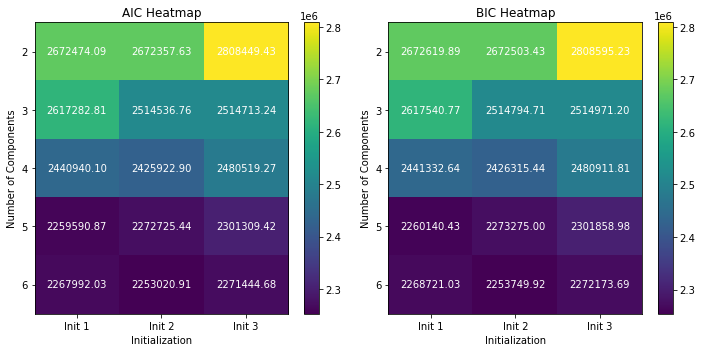

In [118]:
# Generate heatmaps of AIC and BIC
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
n_components_list = list(range(2, 7))
aic = np.array([[results[f'{n}_init_{i}']['aic'] for i in range(n_init)] for n in n_components_list])
bic = np.array([[results[f'{n}_init_{i}']['bic'] for i in range(n_init)] for n in n_components_list])

def plot_heatmap(data, ax, title):
    cax = ax.imshow(data, cmap='viridis', aspect='auto')
    ax.set_xticks(np.arange(n_init))
    ax.set_xticklabels([f'Init {i + 1}' for i in range(n_init)])
    ax.set_yticks(np.arange(len(n_components_list)))
    ax.set_yticklabels(n_components_list)
    ax.set_title(title)
    ax.set_xlabel('Initialization')
    ax.set_ylabel('Number of Components')
    # Annotate each cell with the value
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.text(j, i, f'{data[i, j]:.2f}', ha='center', va='center', color='white')
    plt.colorbar(cax, ax=ax)

plot_heatmap(aic, axs[0], 'AIC Heatmap')
plot_heatmap(bic, axs[1], 'BIC Heatmap')
plt.tight_layout()
plt.show()


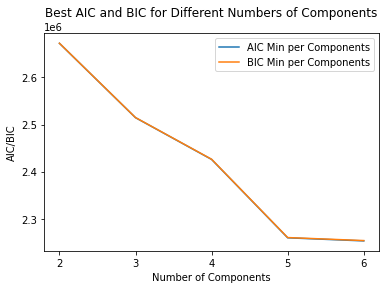

In [119]:
plt.plot(aic.min(axis=1), label='AIC Min per Components')
plt.plot(bic.min(axis=1), label='BIC Min per Components')
plt.xticks(range(len(n_components_list)), n_components_list)
plt.xlabel('Number of Components')
plt.ylabel('AIC/BIC')
plt.title('Best AIC and BIC for Different Numbers of Components')
plt.legend()
plt.show()


In [200]:
# Best model: 5 components, 3rd initialization
# covariance_type='full', n_components=5, n_iter=50, random_state=212
# Selected based on lowest AIC/BIC and elbow method
best_model2 = results['5_init_0']['model']
best_model2


GaussianHMM(covariance_type='full', n_components=5, n_iter=50, random_state=210,
            verbose=True)

## Best Model Analysis

In [158]:
def compute_state_proportions(model, X, lengths):
    """
    Given a fitted HMM model, data X, and sequence lengths,
    returns an array of shape (n_samples, n_states) where each row
    contains the proportion of time spent in each state for a sample.
    """
    states = model.predict(X, lengths=lengths)
    n_states = model.n_components
    n_samples = len(lengths)
    proportions = np.zeros((n_samples, n_states))
    seq_starts = np.cumsum([0] + list(lengths[:-1]))
    seq_ends = np.cumsum(lengths)
    for i, (st, en) in enumerate(zip(seq_starts, seq_ends)):
        sample_states = states[st:en]
        for s in range(n_states):
            proportions[i, s] = np.mean(sample_states == s)
    return proportions


In [185]:
import pandas as pd

states = best_model2.predict(X_train, lengths=lengths_train)  # Predict states for the entire dataset
n_states = states.max() + 1  # number of unique states
n_samples = len(seq_starts) # = len(y_train)

# For each state, compute empirical mean/var for both features
means = []
vars_ = []
for s in range(n_states):
    mask = states == s
    means.append(X_train[mask].mean(axis=0))
    vars_.append(X_train[mask].var(axis=0))

means = np.array(means)
vars_ = np.array(vars_)

# Helper to get start/end indices for each sequence in X_train
seq_starts = np.cumsum([0] + lengths_train[:-1])
seq_ends = np.cumsum(lengths_train)

'''# For each sample, compute proportion of time spent in each state
proportions = np.zeros((n_samples, n_states))
for i in range(n_samples):
    st, en = seq_starts[i], seq_ends[i]
    sample_states = states[st:en]
    for s in range(n_states):
        proportions[i, s] = np.mean(sample_states == s)'''
# Compute state proportions for the training set
proportions = compute_state_proportions(best_model2, X_train, lengths_train)

# Group indices
n_pd = y_train[y_train == 1].sum()  # Number of PD samples
pd_idx = np.arange(n_samples)[y_train == 1]
ctrl_hcp_idx = np.arange(n_samples)[y_train == 0]

# For each state, compute total proportion and percentiles for each group
rows = []
for s in range(n_states):
    # Empirical mean/var
    mean0, mean1 = means[s, 0], means[s, 1]
    var0, var1 = vars_[s, 0], vars_[s, 1]
    # Proportion in each group
    prop_pd = proportions[pd_idx, s].sum() / n_pd
    prop_ctrl_hcp = proportions[ctrl_hcp_idx, s].sum() / (n_samples - n_pd)
    # Percentiles
    pct_pd = np.percentile(proportions[pd_idx, s], [5, 50, 95])
    pct_ctrl_hcp = np.percentile(proportions[ctrl_hcp_idx, s], [5, 50, 95])
    rows.append({
        "State": s,
        "Mean_FD": mean0,
        "Var_FD": var0,
        "Mean_RMSD": mean1,
        "Var_RMSD": var1,
        "Prop_Total_PD": prop_pd,
        "Prop_Total_CtrlHCP": prop_ctrl_hcp,
        "PD_5th": pct_pd[0],
        "PD_50th": pct_pd[1],
        "PD_95th": pct_pd[2],
        "CtrlHCP_5th": pct_ctrl_hcp[0],
        "CtrlHCP_50th": pct_ctrl_hcp[1],
        "CtrlHCP_95th": pct_ctrl_hcp[2],
    })

df_states = pd.DataFrame(rows)
pd.set_option('display.precision', 4)
display(df_states)


,State,Mean_FD,Var_FD,Mean_RMSD,Var_RMSD,Prop_Total_PD,Prop_Total_CtrlHCP,PD_5th,PD_50th,PD_95th,CtrlHCP_5th,CtrlHCP_50th,CtrlHCP_95th
0,0,-0.6456,0.1554,-0.5016,0.2093,0.0045,0.4076,0.0000,0.0000,0.0250,0.1824,0.4235,0.5660
1,1,0.4201,0.7146,-0.5235,0.3951,0.0026,0.2305,0.0000,0.0000,0.0142,0.0818,0.2369,0.3375
2,2,0.3353,0.7012,0.9461,0.2975,0.0046,0.2635,0.0000,0.0000,0.0210,0.1006,0.2746,0.3648
3,3,1.8376,3.4732,1.8053,3.5258,0.0594,0.0496,0.0188,0.0546,0.1134,0.0042,0.0461,0.1069
4,4,-0.1618,0.4621,-0.1650,0.4624,0.9289,0.0488,0.8197,0.9412,0.9790,0.0000,0.0000,0.4486


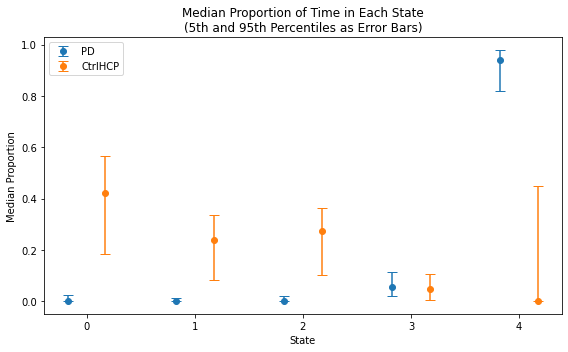

In [186]:
# Boxplot of medians for PD and CtrlHCP with 5th and 95th percentiles as error bars

fig, ax = plt.subplots(figsize=(8, 5))

# Extract medians and error bars from df_states
pd_medians = df_states["PD_50th"]
ctrlhcp_medians = df_states["CtrlHCP_50th"]

pd_err = np.vstack([
    pd_medians - df_states["PD_5th"],
    df_states["PD_95th"] - pd_medians
])
ctrlhcp_err = np.vstack([
    ctrlhcp_medians - df_states["CtrlHCP_5th"],
    df_states["CtrlHCP_95th"] - ctrlhcp_medians
])

positions = np.arange(len(df_states))
width = 0.35

ax.errorbar(
    positions - width/2, pd_medians, yerr=pd_err, fmt='o', label='PD', capsize=5
)
ax.errorbar(
    positions + width/2, ctrlhcp_medians, yerr=ctrlhcp_err, fmt='o', label='CtrlHCP', capsize=5
)

ax.set_xticks(positions)
ax.set_xticklabels(df_states["State"])
ax.set_xlabel("State")
ax.set_ylabel("Median Proportion")
ax.set_title("Median Proportion of Time in Each State\n(5th and 95th Percentiles as Error Bars)")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg2 = LogisticRegression()
prop_state4 = proportions[:, 4].reshape(-1, 1)  # Proportion in state 0
# Train logistic regression on state proportions
#log_reg2.fit(proportions, y_train)
#log_reg2.predict_proba(proportions[:10]), log_reg2.predict(proportions[:10]), y_train[:10]

log_reg2.fit(prop_state4, y_train)
log_reg2.predict_proba(prop_state4[:10]), log_reg2.predict(prop_state4[:10]), y_train[:10]


(array([[0.99312477, 0.00687523],
        [0.99312477, 0.00687523],
        [0.99312477, 0.00687523],
        [0.19648561, 0.80351439],
        [0.15483731, 0.84516269],
        [0.99312477, 0.00687523],
        [0.21536125, 0.78463875],
        [0.99312477, 0.00687523],
        [0.99312477, 0.00687523],
        [0.99312477, 0.00687523]]),
 array([0, 0, 0, 1, 1, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0]))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

prop_state4 = proportions[:, 4]  # Proportion in state 1

# Train a logistic regression model to predict group membership
C_grid = np.logspace(-10, 5, 50)  # Regularization strength grid

# Perform grid search to find the best regularization strength
# (High variance so not that reliable)
log_reg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=RNG_SEED),
    param_grid={'C': C_grid},
    scoring='f1_macro',  # Use F1 score for evaluation
    cv=5,
    verbose=1
)

log_reg.fit(prop_state4.reshape(-1, 1), y_train)
# Best regularization strength
best_C = log_reg.best_params_['C']
print(f"Best regularization strength: {best_C}")
print(f"Best F1 score: {log_reg.best_score_:.4f}")
log_reg_best = log_reg.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best regularization strength: 0.30888435964774846
Best F1 score: 0.9376


In [ ]:

#log_reg2.fit(prop_state1, y_train)
log_reg_best.predict_proba(prop_state4[:10].reshape(-1,1)), log_reg_best.predict(prop_state4[:10].reshape(-1,1)), y_train[:10]


(array([[0.98153693, 0.01846307],
        [0.98153693, 0.01846307],
        [0.98153693, 0.01846307],
        [0.2435265 , 0.7564735 ],
        [0.20350697, 0.79649303],
        [0.98153693, 0.01846307],
        [0.26095494, 0.73904506],
        [0.98153693, 0.01846307],
        [0.98153693, 0.01846307],
        [0.98153693, 0.01846307]]),
 array([0, 0, 0, 1, 1, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0]))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

def predict_probs(hmm, log_reg, X, lengths):
    """
    Predicts logits for each sample in X using the fitted HMM model.
    Returns a tensor of shape (n_samples,) where each row contains the logits
    """
    proportions = compute_state_proportions(hmm, X, lengths)
    prop_state4 = proportions[:, 4]  # Proportion in state 1
    return log_reg.predict_proba(prop_state4.reshape(-1, 1))[:, 1]  # Probability of being in PD group

def evaluate_model(hmm, log_reg, X, lengths, y_true,
                   threshold=0.5, print_report=True):
    """
    Evaluates the model on the given data.
    Returns accuracy, F1 score, confusion matrix, and classification report.
    """
    y_pred_probs = predict_probs(hmm, log_reg, X, lengths)
    y_pred = (y_pred_probs >= threshold).astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    if print_report:
        print("Classification Report:")
        print(classification_report(y_true, y_pred))
        print("Confusion Matrix:")
        print(cm)

    return accuracy, f1, cm


In [ ]:
evaluate_model(best_model2, log_reg_best, X_train, lengths_train, y_train)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1041
           1       0.82      0.99      0.90       224

    accuracy                           0.96      1265
   macro avg       0.91      0.97      0.94      1265
weighted avg       0.97      0.96      0.96      1265

Confusion Matrix:
[[993  48]
 [  2 222]]


(0.9604743083003953,
 0.9371137341616093,
 array([[993,  48],
        [  2, 222]]))

In [199]:
# Combine validation and test sets for final evaluation
# (Since we didn't use validation set for training)
X_combined = np.concatenate([X_val, X_test], axis=0)
lengths_combined = lengths_val + lengths_test
# True labels for combined set
y_combined = np.concatenate([y_val, y_test], axis=0)
# Evaluate on combined validation and test set
accuracy, f1, cm = evaluate_model(best_model2, log_reg_best, 
                                  X_combined, lengths_combined, y_combined,
                                  threshold=0.5)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       448
           1       0.83      1.00      0.91        96

    accuracy                           0.96       544
   macro avg       0.91      0.98      0.94       544
weighted avg       0.97      0.96      0.96       544

Confusion Matrix:
[[428  20]
 [  0  96]]


# Supervised Learning (old)

In [180]:
# ----------------------- Hyper-parameters ----------------------- #
MAX_LEN = 200  # truncate / zero-pad sequences to this length
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RNG_SEED = 42

random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

keys = pd_keys + control_keys
random.shuffle(keys)

# dataset = dp.MotionDataset(data_dict, keys, MAX_LEN)

dataset = dp.MotionDataset(
    datasets=[
        (data_dict_ppmi, pd_keys, 1),         # PPMI PD subjects, label 1
        (data_dict_ppmi, control_keys, 0),    # PPMI Control subjects, label 0
        (data_dict_hcp, list(data_dict_hcp.keys())[:276], 0),  # HCP subjects, label 2 (or 0 if you want to treat as controls)
    ],
    metric_map=[
        "framewise_displacement",              # for PPMI PD
        "framewise_displacement",              # for PPMI Control
        "framewise_displacement_equivalent"    # for HCP
    ],
    max_len=None
)

train_loader, val_loader = te.train_val_split(
        dataset, val_size=0.2, random_state=RNG_SEED, batch_size=1
)


In [181]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        logits = self.linear(x)
        return logits.squeeze()


In [182]:
class GaussianHMM(nn.Module):
    def __init__(self, n_states, n_features):
        super().__init__()
        self.n_states = n_states    # number of hidden states (K)
        self.n_features = n_features    # number of features (F)

        self.log_pi = nn.Parameter(torch.randn(n_states))  # log initial state probs
        self.log_trans = nn.Parameter(
            torch.eye(n_states) + 0.1 * torch.randn(n_states, n_states)
        )  # log transition matrix
    
        self.means = nn.Parameter(torch.randn(n_states, n_features))
        self.log_vars = nn.Parameter(
            torch.full((n_states, n_features), np.log(0.5))
        )  # diag covariances

    def emission_log_prob(self, x):
        # x: (T, F), returns: (T, K)
        T, F = x.shape
        x = x.unsqueeze(1)  # (T, 1, F)
        means = self.means.unsqueeze(0)  # (1, K, F)
        vars = torch.exp(self.log_vars).unsqueeze(0)  # (1, K, F)

        log_probs = Normal(means, torch.sqrt(vars)).log_prob(x).sum(-1)  # (T, K)
        return log_probs

    def log_likelihood(self, x):
        # Forward algorithm in log space
        T = x.shape[0]
        log_emissions = self.emission_log_prob(x)  # (T, K)

        log_alpha = torch.zeros_like(log_emissions)
        log_A = F.log_softmax(self.log_trans, dim=1)  # (K, K)
        log_pi = F.log_softmax(self.log_pi, dim=0)  # (K,)

        log_alpha[0] = log_pi + log_emissions[0]
        for t in range(1, T):
            prev = log_alpha[t - 1].unsqueeze(1) + log_A  # (K, K)
            log_alpha[t] = torch.logsumexp(prev, dim=0) + log_emissions[t]  # (K,)

        return torch.logsumexp(log_alpha[-1], dim=0)  # scalar
    
    # Forward-Backward algorithm to compute posterior state probabilities
    # P(z_t = k | x_{1:T}) for each time step t and state k
    def posterior_state_probs(self, x):
        """Returns gamma_t(k) = P(z_t = k | x_{1:T})"""
        T = x.shape[0]
        log_emissions = self.emission_log_prob(x)  # (T, K)
        log_A = F.log_softmax(self.log_trans, dim=1)  # (K, K)
        log_pi = F.log_softmax(self.log_pi, dim=0)  # (K,)

        # Forward pass
        log_alpha = torch.zeros_like(log_emissions)
        log_alpha[0] = log_pi + log_emissions[0]
        for t in range(1, T):
            log_alpha[t] = torch.logsumexp(log_alpha[t - 1].unsqueeze(1) + log_A, dim=0) + log_emissions[t]

        # Backward pass
        log_beta = torch.zeros_like(log_emissions)
        for t in reversed(range(T - 1)):
            log_beta[t] = torch.logsumexp(log_A + log_emissions[t + 1] + log_beta[t + 1], dim=1)

        log_gamma = log_alpha + log_beta  # unnormalized log posterior
        log_gamma -= torch.logsumexp(log_gamma, dim=1, keepdim=True)  # normalize
        return torch.exp(log_gamma)  # shape (T, K)

class HMMClassifier(nn.Module):
    def __init__(self, n_states, n_features):
        super().__init__()
        self.hmm_pd = GaussianHMM(n_states, n_features)
        self.hmm_ctrl = GaussianHMM(n_states, n_features)

    def forward(self, x):
        logp_pd = self.hmm_pd.log_likelihood(x)
        logp_ctrl = self.hmm_ctrl.log_likelihood(x)
        logits = torch.stack([logp_ctrl, logp_pd])  # [log P(control), log P(PD)]
        return logits


In [183]:
class GaussianEmission(nn.Module):
    def __init__(self, n_states, obs_dim):
        super().__init__()
        self.means = nn.Parameter(torch.randn(n_states, obs_dim))
        self.log_vars = nn.Parameter(torch.zeros(n_states, obs_dim))  # log(σ²)

    def log_prob(self, x):
        # x: (T, F), returns: (T, K)
        T, F = x.shape
        x = x.unsqueeze(1)  # (T, 1, F)
        means = self.means.unsqueeze(0)  # (1, K, F)
        vars = torch.exp(self.log_vars).unsqueeze(0)  # (1, K, F)

        log_probs = Normal(means, torch.sqrt(vars)).log_prob(x).sum(-1)  # (T, K)
        return log_probs

class TransitionModel(nn.Module):
    def __init__(self, n_states):
        super().__init__()
        self.log_pi = nn.Parameter(torch.randn(n_states))  # initial state
        self.log_trans = nn.Parameter(torch.randn(n_states, n_states))  # transitions

class SharedEmissionHMM(nn.Module):
    def __init__(self, transition_model: TransitionModel, emission_model: GaussianEmission):
        super().__init__()
        self.trans = transition_model
        self.emission = emission_model

    def log_likelihood(self, x):
        T = x.shape[0]
        log_emit = self.emission.log_prob(x)  # (T, K)
        log_A = F.log_softmax(self.trans.log_trans, dim=1)  # (K, K)
        log_pi = F.log_softmax(self.trans.log_pi, dim=0)  # (K,)

        log_alpha = torch.zeros_like(log_emit)
        log_alpha[0] = log_pi + log_emit[0]
        for t in range(1, T):
            log_alpha[t] = torch.logsumexp(log_alpha[t - 1].unsqueeze(1) + log_A, dim=0) + log_emit[t]

        return torch.logsumexp(log_alpha[-1], dim=0)

    def posterior_state_probs(self, x):
        T = x.shape[0]
        log_emit = self.emission.log_prob(x)  # (T, K)
        log_A = F.log_softmax(self.trans.log_trans, dim=1)  # (K, K)
        log_pi = F.log_softmax(self.trans.log_pi, dim=0)  # (K,)

        log_alpha = torch.zeros_like(log_emit)
        log_alpha[0] = log_pi + log_emit[0]
        for t in range(1, T):
            log_alpha[t] = torch.logsumexp(log_alpha[t - 1].unsqueeze(1) + log_A, dim=0) + log_emit[t]

        log_beta = torch.zeros_like(log_emit)
        for t in reversed(range(T - 1)):
            log_beta[t] = torch.logsumexp(log_A + log_emit[t + 1] + log_beta[t + 1], dim=1)

        log_gamma = log_alpha + log_beta
        log_gamma -= torch.logsumexp(log_gamma, dim=1, keepdim=True)
        return torch.exp(log_gamma)  # (T, K)

class HMMClassifier2(nn.Module):
    def __init__(self, n_states, n_features):
        super().__init__()
        self.emission = GaussianEmission(n_states, n_features)
        self.trans_ctrl = TransitionModel(n_states)
        self.trans_pd = TransitionModel(n_states)

        self.hmm_ctrl = SharedEmissionHMM(self.trans_ctrl, self.emission)
        self.hmm_pd = SharedEmissionHMM(self.trans_pd, self.emission)

    def forward(self, x):
        logp_ctrl = self.hmm_ctrl.log_likelihood(x)
        logp_pd = self.hmm_pd.log_likelihood(x)
        logits = torch.stack([logp_ctrl, logp_pd])  # shape (2,)
        return logits


In [192]:
def transition_entropy_penalty(log_trans):
    # log_trans: raw logits (K, K) — nn.Parameter
    probs = F.softmax(log_trans, dim=1)        # (K, K)
    log_probs = F.log_softmax(log_trans, dim=1)  # (K, K)
    entropy = -torch.sum(probs * log_probs, dim=1)  # (K,)
    return entropy.mean()  # scalar


def train_epoch(model, X, y, optimizer, batch_size=16, lambda_entropy=0):
    model.train()
    losses = []
    optimizer.zero_grad()

    for i in range(len(X)):
        x = X[i].to(DEVICE)
        label = y[i].item()
        x = x.view(-1, x.shape[-1])

        logits = model(x)
        target = torch.tensor([label], dtype=torch.long)

        loss = F.cross_entropy(logits.unsqueeze(0), target)

        # Compute entropy penalties
        if isinstance(model, HMMClassifier2) and lambda_entropy > 0:
            entropy_ctrl = transition_entropy_penalty(model.trans_ctrl.log_trans)
            entropy_pd = transition_entropy_penalty(model.trans_pd.log_trans)
            entropy_penalty = -(entropy_ctrl + entropy_pd) / 2  # negative to penalize low entropy
            loss += lambda_entropy * entropy_penalty

        loss.backward()
        losses.append(loss.item())

        # Take step every `batch_size` samples
        if (i + 1) % batch_size == 0 or (i + 1) == len(X):
            optimizer.step()
            optimizer.zero_grad()

    return losses

# For variable length (max_len=None), using DataLoader (batch_size=1) to handle each sequence individually
def train_epoch_vl(model, train_loader, optimizer, batch_size=32, lambda_entropy=0):
    model.train()
    losses = []
    optimizer.zero_grad()
    for i, batch in enumerate(train_loader):
        X, y = batch
        X = X.to(DEVICE)
        y = y.to(DEVICE)

        # Flatten the batch
        X = X.view(-1, X.shape[-1])

        logits = model(X)
        target = y.view(-1)

        loss = F.cross_entropy(logits, target)

        # Compute entropy penalties
        if isinstance(model, HMMClassifier2) and lambda_entropy > 0:
            entropy_ctrl = transition_entropy_penalty(model.trans_ctrl.log_trans)
            entropy_pd = transition_entropy_penalty(model.trans_pd.log_trans)
            entropy_penalty = -(entropy_ctrl + entropy_pd) / 2  # negative to penalize low entropy
            loss += lambda_entropy * entropy_penalty
        
        loss /= X.shape[-1] # normalize by sequence length
        loss.backward()
        losses.append(loss.item())

        # Take step every `batch_size` samples
        if (i + 1) % batch_size == 0 or (i + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()
        
    return losses

def evaluate(model, X):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for i in range(len(X)):
            x = X[i].to(DEVICE)
            x = x.view(-1, x.shape[-1])
            
            logits = model(x)
            pred = torch.argmax(logits).item()
            y_pred.append(pred)
    y_pred = np.array(y_pred)
    return y_pred

def evaluate_vl(model, val_loader):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for batch in val_loader:
            X, _ = batch
            X = X.to(DEVICE)
            X = X.view(-1, X.shape[-1])
            
            logits = model(X)
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            y_pred.extend(pred)
    return np.array(y_pred)


In [ ]:
for X, y in val_loader:
    print(X.shape[1])


In [191]:
X_train, y_train = dp.get_data_from_loader(train_loader)
X_val, y_val = dp.get_data_from_loader(val_loader)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

NOISE_STD = 0  # Standard deviation for noise in the data

torch.manual_seed(RNG_SEED)
np.random.seed(RNG_SEED)

X_train += torch.randn_like(X_train) * NOISE_STD


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 238 but got size 208 for tensor number 4 in the list.

/var/folders/gn/n4hz1bh52t190f6wd1mfjtzr0000gn/T/ipykernel_8996/1246804388.py:20: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  target = torch.tensor([label], dtype=torch.long)


Epoch 5/80, Loss: 0.7531, Train Acc: 0.5430, Val Acc: 0.5000
Epoch 10/80, Loss: 0.7220, Train Acc: 0.5488, Val Acc: 0.4922
Epoch 15/80, Loss: 0.7021, Train Acc: 0.5625, Val Acc: 0.5078
Epoch 20/80, Loss: 0.6936, Train Acc: 0.5703, Val Acc: 0.4922
Epoch 25/80, Loss: 0.6891, Train Acc: 0.5703, Val Acc: 0.4766
Epoch 30/80, Loss: 0.6878, Train Acc: 0.5703, Val Acc: 0.4844
Epoch 35/80, Loss: 0.6876, Train Acc: 0.5645, Val Acc: 0.4844
Epoch 40/80, Loss: 0.6870, Train Acc: 0.5957, Val Acc: 0.4766
Epoch 45/80, Loss: 0.6861, Train Acc: 0.6270, Val Acc: 0.5000
Epoch 50/80, Loss: 0.6845, Train Acc: 0.6426, Val Acc: 0.5234
Epoch 55/80, Loss: 0.6813, Train Acc: 0.6719, Val Acc: 0.5312
Epoch 60/80, Loss: 0.6770, Train Acc: 0.7559, Val Acc: 0.5312
Epoch 62/80, Loss: 0.6753, Train Acc: 0.7773, Val Acc: 0.5391
Epoch 63/80, Loss: 0.6744, Train Acc: 0.7852, Val Acc: 0.5469
Epoch 64/80, Loss: 0.6736, Train Acc: 0.7988, Val Acc: 0.5547
Epoch 65/80, Loss: 0.6728, Train Acc: 0.7969, Val Acc: 0.5703
Epoch 66/

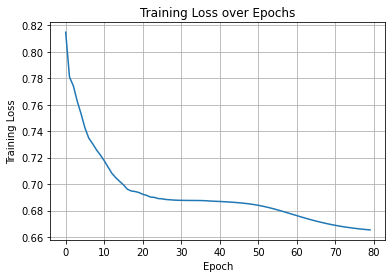

In [ ]:
# 0.625
'''EPOCHS = 66
LR = 4e-3
WD = 10
N_STATES = 2  # Number of hidden states in the HMM
LAM_ENTROPY = 0  # Entropy penalty coefficient
BATCH_SIZE = 32
'''

# 0.625 (bad)
'''EPOCHS = 60
LR = 4e-3
WD = 10
N_STATES = 2  # Number of hidden states in the HMM
BATCH_SIZE = 16
'''

# 0.625
'''EPOCHS = 67
LR = 8e-3
WD = 20
N_STATES = 2  # Number of hidden states in the HMM
BATCH_SIZE = 64'''

EPOCHS = 80
LR = 4e-3
WD = 10
N_STATES = 3  # Number of hidden states in the HMM
LAM_ENTROPY = 0  # Entropy penalty coefficient
BATCH_SIZE = 32
LAM_ENTROPY = 0

torch.manual_seed(RNG_SEED)
np.random.seed(RNG_SEED)

#X_train2 = X_train + NOISE_STD * torch.randn_like(X_train)

model = HMMClassifier2(n_states=N_STATES, n_features=MAX_LEN)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
train_losses = []
for epoch in range(EPOCHS):
    losses = train_epoch(model, X_train, y_train, optimizer, 
                         batch_size=BATCH_SIZE,
                         lambda_entropy=LAM_ENTROPY)
    train_loss = np.mean(losses)
    train_losses.append(train_loss)
    if ((epoch + 1) % 5 == 0) or epoch > 60:
        train_pred = evaluate(model, X_train)
        train_acc = np.mean(train_pred == y_train.to(int).numpy())
        y_pred = evaluate(model, X_val)
        val_acc = np.mean(y_pred == y_val.to(int).numpy())
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Evaluate on validation set
y_pred = evaluate(model, X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Control", "PD"]))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot training loss
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()


In [ ]:
# Next: var-length inputs, mask padding, autoregressive HMM


In [ ]:
EPOCHS = 80
LR = 4e-3
WD = 10
N_STATES = 2  # Number of hidden states in the HMM
BATCH_SIZE = 32

torch.manual_seed(RNG_SEED)
np.random.seed(RNG_SEED)

#X_train2 = X_train + NOISE_STD * torch.randn_like(X_train)

model = HMMClassifier2(n_states=N_STATES, n_features=MAX_LEN)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
train_losses = []
for epoch in range(EPOCHS):
    losses = train_epoch_vl(model, train_loader, optimizer, 
                           batch_size=BATCH_SIZE,
                           lambda_entropy=LAM_ENTROPY)
    train_loss = np.mean(losses)
    train_losses.append(train_loss)
    if ((epoch + 1) % 5 == 0) or epoch > 60:
        train_pred = evaluate_vl(model, train_loader)
        train_acc = np.mean(train_pred == y_train.to(int).numpy())
        y_pred = evaluate(model, X_val)
        val_acc = np.mean(y_pred == y_val.to(int).numpy())
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Evaluate on validation set
y_pred = evaluate(model, X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Control", "PD"]))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot training loss
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()


ValueError: Value is not broadcastable with batch_shape+event_shape: torch.Size([1, 1, 238]) vs torch.Size([1, 2, 200]).


Training Logistic Regression…


Epoch 20/40  loss=55.3116  val_acc=0.508  val_bal_acc=0.510  val_auc=0.534


Epoch 40/40  loss=56.6506  val_acc=0.555  val_bal_acc=0.553  val_auc=0.561


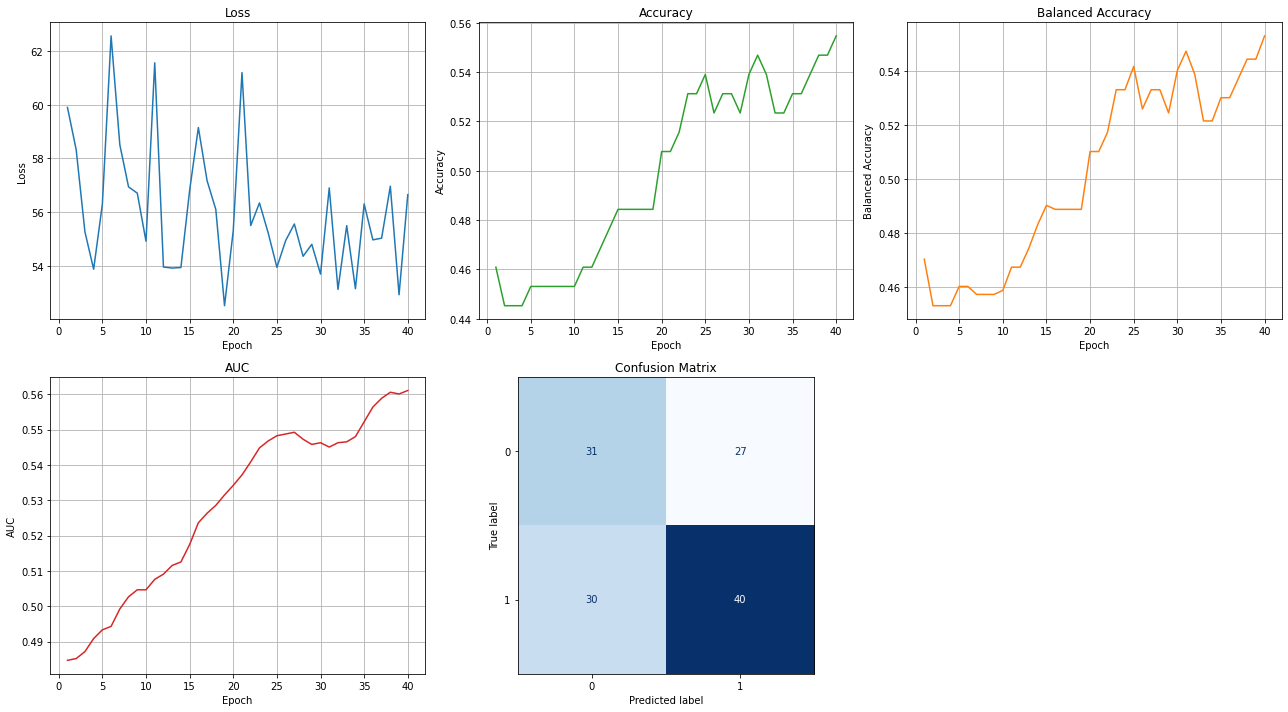

Logistic Regression final  ACC=0.555  BAL_ACC=0.553  AUC=0.561
Confusion matrix:
 [[31 27]
 [30 40]]
              precision    recall  f1-score   support

         0.0      0.508     0.534     0.521        58
         1.0      0.597     0.571     0.584        70

    accuracy                          0.555       128
   macro avg      0.553     0.553     0.552       128
weighted avg      0.557     0.555     0.555       128



In [ ]:
#EPOCHS = 80
#LR = 1e-4
#WD = 1e-3

EPOCHS = 40
LR = 2e-4
WD = 1e-4

torch.manual_seed(RNG_SEED)

models = {
    #"Logistic Regression": LogisticRegression(input_dim=MAX_LEN),
    "HMM Classifier": HMMClassifier(n_states=5, n_features=MAX_LEN),
}

for name, model in models.items():
    print(f"\nTraining {name}…")
    te.train(
        model, train_loader, val_loader,
        device=DEVICE, epochs=EPOCHS, lr=LR, weight_decay=WD
    )
    acc, bal_acc, auc, _, _ = te.evaluate(model, val_loader, device=DEVICE)
    print(
        f"{name} final  ACC={acc:.3f}  BAL_ACC={bal_acc:.3f}  AUC={auc:.3f}"
    )

    preds, targets = te.get_predictions(model, val_loader, device=DEVICE)
    cm = confusion_matrix(targets, preds)
    print("Confusion matrix:\n", cm)
    print(classification_report(targets, preds, digits=3))


In [64]:
# Compute the mean of the target labels (y) from the validation loader
y_vals = []
X_vals = []
for X, y in val_loader:
    X_vals.extend(X.cpu().numpy())
    y_vals.extend(y.cpu().numpy())
y_mean = np.mean(y_vals)
X_vals = np.array(X_vals)
y_vals = np.array(y_vals)
print("Mean of y in val_loader:", y_mean)
X_vals.shape, y_vals.shape


Mean of y in val_loader: 0.546875


((128, 200), (128,))

In [11]:
models = {
    "GRU": mnn.RNNClassifier(cell="gru"),
    "LSTM": mnn.RNNClassifier(cell="lstm"),
    "Transformer": mnn.TransformerClassifier()
}

for name, model in models.items():
    print(f"\nTraining {name}…")
    te.train(
        model, train_loader, val_loader,
        device=DEVICE, epochs=EPOCHS, lr=LR,
    )
    acc, bal_acc, auc, _, _ = te.evaluate(model, val_loader, device=DEVICE)
    print(
        f"{name} final  ACC={acc:.3f}  BAL_ACC={bal_acc:.3f}  AUC={auc:.3f}"
    )

    preds, targets = te.get_predictions(model, val_loader, device=DEVICE)
    cm = confusion_matrix(targets, preds)
    print("Confusion matrix:\n", cm)
    print(classification_report(targets, preds, digits=3))



Training GRU…
Epoch 05/100  val_acc=0.486  val_bal_acc=0.602  val_auc=0.699
Epoch 10/100  val_acc=0.847  val_bal_acc=0.586  val_auc=0.635
Epoch 15/100  val_acc=0.792  val_bal_acc=0.609  val_auc=0.525
Epoch 20/100  val_acc=0.681  val_bal_acc=0.602  val_auc=0.557
Epoch 25/100  val_acc=0.694  val_bal_acc=0.500  val_auc=0.412
Epoch 30/100  val_acc=0.764  val_bal_acc=0.484  val_auc=0.582
Epoch 35/100  val_acc=0.722  val_bal_acc=0.570  val_auc=0.539
Epoch 40/100  val_acc=0.833  val_bal_acc=0.688  val_auc=0.598
Epoch 45/100  val_acc=0.792  val_bal_acc=0.500  val_auc=0.590
Epoch 50/100  val_acc=0.736  val_bal_acc=0.469  val_auc=0.580
Epoch 55/100  val_acc=0.750  val_bal_acc=0.477  val_auc=0.582
Epoch 60/100  val_acc=0.778  val_bal_acc=0.547  val_auc=0.598
Epoch 65/100  val_acc=0.750  val_bal_acc=0.586  val_auc=0.586
Epoch 70/100  val_acc=0.764  val_bal_acc=0.484  val_auc=0.646
Epoch 75/100  val_acc=0.764  val_bal_acc=0.430  val_auc=0.600
Epoch 80/100  val_acc=0.778  val_bal_acc=0.438  val_auc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
